<h1 style="text-decoration:underline;text-decoration:bold;text-align:center;"> 
    <b> Experimental Elastic Scattering Cross-Section Calculations (Classical) </b> 
</h1>

<h2 style="text-align:center;"> 
    39K(3He,3He)40Ca
</h2>

## Note: This notebook is obsolete. The new version is included in the transfer analysis: Transfer-Analysis/TransferCrossSections.ipynb

## This notebook does the following:
#### 1. Imports experimental elastic scattering run data and yield data from EngeSpec fits
#### 2. Calculates experimental elastic scattering cross-sections given nuclear physics and yield inputs
#### 3. Imports Fresco elastic scattering input file using a 3He global optical model potential (OMP)
#### 4. Compares the experimental data with the 3He global OMP

***

## Prerequisites:
#### 1.  Acquire fit parameters in text file for the P1 (Front Position) spectrum at each angle
#### 2.  Acquire fit parameters in text file for the Si detector spectrum at each angle
#### 3.  Tabulate run data in a spreadsheet to upload
#### 4.  Acquire Fresco elastic scattering input file with 3He global OMP

***

<h2 style="text-decoration:underline;"> 
    Imported Libraries
</h2>

In [1]:
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import re

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Inputs
</h1>

<h2 style="text-decoration:underline;"> 
    Inputs for EngeSpec Data
</h2>

In [2]:
f_EngeSpec_P1_fit_data = '../../Data/Yields_ES.dat' #Front Position (P1)
f_EngeSpec_Si_fit_data = '../../Data/Yields_Si_ES.dat' # Si Detector

num_params = 4 # number of fit parameters recorded (centroid, centroid uncertainty, peak area, etc..)
num_peaks_P1 = 1 # number of peaks in the P1 spectrum in which fit data was recorded (just 39K peak for now)

<h2 style="text-decoration:underline;"> 
    Inputs for Nuclear Physics
</h2>

In [3]:
f_run_data = '../../Data/ES-Spreadsheet.ods' # Spreadsheet with run data
ES_reaction = '39K(3He, 3He)40Ca'
# If removing 15 deg, include line to skip importing 15 deg run data
Theta_lab = [15, 20, 25, 30, 35, 40, 45, 50, 55, 59] # lab angles (15 deg 39K peak overlaps I peak in P1 spectrum. Assuming it forms a triple Gaussian, and the left-most peak is 39K)
#Theta_lab = [20, 25, 30, 35, 40, 45, 50, 55, 59] # lab angles (15 deg 39K peak overlaps I peak in P1 spectrum. Don't include until all fits are done with BayeSpec)

# Lab angles of the most stable portion of the target degradation (TD) plot. TD = Si peak area / BCI
# Taking an average of the Si peak area / BCI over these angles and correcting the cross-sections by this ratio
Si_Detector_Normalization_Angles = [35, 40, 45, 50]

E_lab = 21 # projectile (beam) lab energy in MeV
u_E_lab = E_lab * 50 / (10**6) # uncertainty in projectile (beam) lab energy in MeV - 50 ppm of beam energy
x_prime = 0.0751 # Thickness per area of target [mg/cm^2]
BCI_scale = 10**(-10) # in Coulombs/pulse - from target current readout module in control room
zp = 2 # Unit charge of projectile
zt = 19 # Unit charge of target (isotope of interest in target molecule)
nu = 1 # Number of atoms of interest in target molecule (stoicheometry) - e.g. K in KI --> 1, Al in Al2O3 --> 2
At_molecule = 166.00277 # Atomic mass of target molecule [g/mole or u] - from www.webqc.org/molecular-weight-of-KI.html
u_At_molecule = 0.00013 # [g/mole or u]

# Atomic masses from 2020 AME Evaluation - Meng Wang et al 2021 Chinese Phys. C 45 030003
Ap_atomic =  3016029.32197 * 10**(-6) # Atomic mass of projectile [g/mole or u]
u_Ap_atomic = 0.00006 * 10**(-6) # Uncertainty of atomic mass of projectile [g/mole or u]
At_atomic =  38963706.487 * 10**(-6) # Atomic mass of isotope of interest in target [g/mole or u]
u_At_atomic = 0.005 * 10**(-6) # Uncertainty of atomic mass of isotope of interest in target [g/mole or u]

# Target contaminant masses for calibration purposes
A_carbon_atomic = 12000000.0 * 10**(-6)
u_A_carbon_atomic = 0.0 * 10**(-6)
A_oxygen_atomic = 15994914.6193 * 10**(-6) # Atomic mass of 16O [g/mole or u]
u_A_oxygen_atomic = 0.0003 * 10**(-6)
A_iodine_atomic = 126904473 * 10**(-6)
u_A_iodine_atomic = 4 * 10**(-6)

# Electron mass and unified atomic mass unit 'u' conversion to eV from 2020 AME Evaluation - W.J. Huang et al 2021 Chinese Phys. C 45 030002
Aelectron = 548579.909065 * 10**(-9) # [g/mole or u]
u_Aelectron = 0.000016 * 10**(-9) # [g/mole or u]
uam_eV = 931494.10242 * 10**(3) # [1 u = uam_eV eV]
u_uam_eV = 0.00028 * 10**(3)
uam_kg = 1660539.0666 * 10**(-33) # [1 u = uam_kg kg]
u_uam_kg = 0.0005 * 10**(-33)

# Meng Wang et al 2021 Chinese Phys. C 45 030003
# M_N = M_A - (Z * Aelectron) + B_e
def atomic_to_nuclear_mass_conversion(atomic_mass, Z):
    return atomic_mass - (Z * Aelectron) + (((14.4381 * Z**(2.39)) + (1.55468 * 10**(-6) * Z**(5.35))) / uam_eV)

# Nuclear Masses
Ap = atomic_to_nuclear_mass_conversion(Ap_atomic, zp)
At = atomic_to_nuclear_mass_conversion(At_atomic, zt)

A_carbon = atomic_to_nuclear_mass_conversion(A_carbon_atomic, 6)
A_oxygen = atomic_to_nuclear_mass_conversion(A_oxygen_atomic, 8)
A_iodine = atomic_to_nuclear_mass_conversion(A_iodine_atomic, 53)

print('Uncertainty in beam lab energy = ' + str(u_E_lab) + ' MeV')
print('Number of Angles = ' + str(len(Theta_lab)))

print('Projectile Nuclear Mass = ' + str(Ap) + ' u')
print('Target Nuclear Mass = ' + str(At) + ' u')

print('C12 Nuclear Mass = ' + str(A_carbon) + ' u')
print('O16 Nuclear Mass = ' + str(A_oxygen) + ' u')
print('I127 Nuclear Mass = ' + str(A_iodine) + ' u')

Uncertainty in beam lab energy = 0.00105 MeV
Number of Angles = 10
Projectile Nuclear Mass = 3.0149322433959993 u
Target Nuclear Mass = 38.953301122441 u
C12 Nuclear Mass = 11.996709642876269 u
O16 Nuclear Mass = 15.990528212247694 u
I127 Nuclear Mass = 126.8756058750795 u


<h2 style="text-decoration:underline;"> 
    Kinematics Calculations for Energy Calibration
</h2>

In [4]:
# Eq. C.5 of Nuclear Physics of Stars (Reduced version for elastic scattering)
def calc_Brho_ES(proj_mass, target_mass, proj_energy, ejected_charge, angle): # NUCLEAR masses in u, energy in MeV, angle in degrees
    r = proj_mass * np.sqrt(proj_energy) * np.cos(angle * np.pi / 180) / (proj_mass + target_mass)
    s = proj_energy * (target_mass - proj_mass) / (proj_mass + target_mass)
    ejected_energy = (r + np.sqrt((r)**2 + s))**2 # Assuming positive solution, discarding negative [in MeV]
    
    ejected_mass_kg = proj_mass * uam_kg
    E_J = ejected_energy * 10**(6) * 1.602176634 * 10**(-19)
    q_C = ejected_charge * 1.602176634 * 10**(-19)
    
    Brho_ES = np.sqrt(2 * ejected_mass_kg * E_J) / q_C
    return Brho_ES

def calc_Brho_ES_FPPlot(proj_mass, target_mass, proj_energy, ejected_charge, angle): # NUCLEAR masses in u, energy in MeV, angle in degrees
    r = proj_mass * np.sqrt(proj_energy) * np.cos(angle * np.pi / 180) / (proj_mass + target_mass)
    s = proj_energy * (target_mass - proj_mass) / (proj_mass + target_mass)
    ejected_energy = (r + np.sqrt((r)**2 + s))**2 # Assuming positive solution, discarding negative [in MeV]
    
    Brho_ES = 143.97 * np.sqrt(proj_mass * ejected_energy) / ejected_charge
    return Brho_ES

def calc_QBrho_ES_ekGcm(proj_mass, target_mass, proj_energy, ejected_charge, angle): # NUCLEAR masses in u, energy in MeV, angle in degrees
    r = proj_mass * np.sqrt(proj_energy) * np.cos(angle * np.pi / 180) / (proj_mass + target_mass)
    s = proj_energy * (target_mass - proj_mass) / (proj_mass + target_mass)
    ejected_energy = (r + np.sqrt((r)**2 + s))**2 # Assuming positive solution, discarding negative [in MeV]
    
    ejected_mass_kg = proj_mass * uam_kg
    E_J = ejected_energy * 10**(6) * 1.602176634 * 10**(-19)
    
    QBrho_ES = np.sqrt(2 * ejected_mass_kg * E_J) # In C*T*m
    QBrho_ES_ekGcm = QBrho_ES * 10**3 / (1.602176634 * 10**(-19))
    return QBrho_ES_ekGcm

C12_3He_3He_Brho = [] # In T*m
O16_3He_3He_Brho = [] # In T*m
K39_3He_3He_Brho = [] # In T*m
I127_3He_3He_Brho = [] # In T*m
for i in Theta_lab:
    C12_3He_3He_Brho.append(calc_Brho_ES(Ap, A_carbon, E_lab, zp, i))
    O16_3He_3He_Brho.append(calc_Brho_ES(Ap, A_oxygen, E_lab, zp, i))
    K39_3He_3He_Brho.append(calc_Brho_ES(Ap, At, E_lab, zp, i))
    I127_3He_3He_Brho.append(calc_Brho_ES(Ap, A_iodine, E_lab, zp, i))

C12_3He_3He_QBrho = [] # In e*kG*cm
O16_3He_3He_QBrho = [] # In e*kG*cm
K39_3He_3He_QBrho = [] # In e*kG*cm
I127_3He_3He_QBrho = [] # In e*kG*cm
for i in Theta_lab:
    C12_3He_3He_QBrho.append(calc_QBrho_ES_ekGcm(Ap, A_carbon, E_lab, zp, i))
    O16_3He_3He_QBrho.append(calc_QBrho_ES_ekGcm(Ap, A_oxygen, E_lab, zp, i))
    K39_3He_3He_QBrho.append(calc_QBrho_ES_ekGcm(Ap, At, E_lab, zp, i))
    I127_3He_3He_QBrho.append(calc_QBrho_ES_ekGcm(Ap, A_iodine, E_lab, zp, i))

print('\nC12(3He,3He) Brho [T*m]:')
print(C12_3He_3He_Brho)
print('\nO16(3He,3He) Brho [T*m]:')
print(O16_3He_3He_Brho)
print('\nK39(3He,3He) Brho [T*m]:')
print(K39_3He_3He_Brho)
print('\nI127(3He,3He) Brho [T*m]:')
print(I127_3He_3He_Brho)

print('\n')
print('\nC12(3He,3He) QBrho [e*kG*cm]:')
print(C12_3He_3He_QBrho)
print('\nO16(3He,3He) QBrho [e*kG*cm]:')
print(O16_3He_3He_QBrho)
print('\nK39(3He,3He) QBrho [e*kG*cm]:')
print(K39_3He_3He_QBrho)
print('\nI127(3He,3He) QBrho [e*kG*cm]:')
print(I127_3He_3He_QBrho)


C12(3He,3He) Brho [T*m]:
[0.5679104034336847, 0.564167759489176, 0.559432073010586, 0.553758852329578, 0.5472140648050389, 0.5398730397095919, 0.5318192024637408, 0.523142660703296, 0.5139386688747936, 0.506262014196961]

O16(3He,3He) Brho [T*m]:
[0.5691293427841951, 0.5663167045768465, 0.5627538426951079, 0.558479624635435, 0.5535402745622253, 0.5479886375500825, 0.5418833407810691, 0.5352878680657555, 0.5282695669523809, 0.5223975779371108]

K39(3He,3He) Brho [T*m]:
[0.5712908937727, 0.5701317939415304, 0.5686598572731372, 0.5668885127387353, 0.5648338233632674, 0.5625142865172035, 0.5599506070566133, 0.5571654475551965, 0.5541831602650452, 0.5516726695616452]

I127(3He,3He) Brho [T*m]:
[0.5723360837716074, 0.5719794045188726, 0.571525802562837, 0.570978951722814, 0.5703432706416637, 0.5696238813644685, 0.5688265617311514, 0.5679576922065284, 0.567024197831301, 0.5662358356761953]



C12(3He,3He) QBrho [e*kG*cm]:
[1135.8208068673694, 1128.335518978352, 1118.864146021172, 1107.517704

<h2 style="text-decoration:underline;"> 
    Inputs for Fresco
</h2>

In [5]:
# Root path containing all fresco files related to this experiment
# e.g. full path to an ES (fort.201) file would be fresco_root/fort.201
# all possible lnj combinations for each excited state are stored in this kind of file tree
#fresco_root = '/home/wcfox/Software/fresco-3.4/3He-ES/Input/'
fresco_root = '../../Data/Input_ES/'

# Extracted data from Vernotte paper
#literature_root = '/home/wcfox/Software/fresco-3.4/3He-ES/Papers/Vernotte/'
literature_root = '../../Data/Vernotte/'
literature_exp_data = 'Vernotte_Data.xls'

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Initial Calculations and Importing Data
</h1>

<h2 style="text-decoration:underline;"> 
    Importing EngeSpec Fit Data
</h2>

In [6]:
def import_data(text_file):
    file = open(text_file, 'r')
    lines = file.read().splitlines()
    data = []
    for line in lines:
        if not (line == ''):
            if not (line[0] == '#'):
                data.append(float(line.strip()))
    file.close()
    return data

# EngeSpec Front Position (P1) peak fit data
data_P1 = import_data(f_EngeSpec_P1_fit_data)

# EngeSpec Si Spectrum peak fit data
data_Si  = import_data(f_EngeSpec_Si_fit_data)

<h2 style="text-decoration:underline;"> 
    Importing Run Data
</h2>

In [7]:
# Load spreadsheet with run data
if (re.search('.ods', f_run_data) == None):
    tab = pd.read_excel(f_run_data, engine = 'openpyxl') #.xlsx files
else:
    tab = pd.read_excel(f_run_data, engine = 'odf') #.ods files

In [8]:
# Extract run data
BCI = []
omega = []
eff = []
clock = []
clocklive = []
run_num = []
for i in tab.index:
    #if (i > 0): # Skip 15 degree data
    BCI.append(tab['BCI'][i])
    omega.append(tab['Omega (msr)'][i])
    eff.append(tab['Efficiency'][i])
    clock.append(tab['Clock'][i])
    clocklive.append(tab['Clock Live'][i])
    run_num.append(tab['Run Number'][i])

<h2 style="text-decoration:underline;"> 
    Calculating Run Quantities
</h2>

In [9]:
q = []
for i in BCI:
    q.append(i * BCI_scale * 1000)
    
deadtime = []
livetime = []
for i in range(len(clock)):
    deadtime.append(1 - (clocklive[i]/clock[i]))
    livetime.append(clocklive[i]/clock[i])
    
run_num_increment = []
for i in range(len(run_num)):
    run_num_increment.append(i+1)
print('Incrementing run numbers:')
print(run_num_increment)

Incrementing run numbers:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<h2 style="text-decoration:underline;"> 
    Conversion from Lab to Center-of-Mass Coordinates
</h2>

### Energy and Angle Conversions:

\begin{equation}
E_{CM} = E_{Lab} \frac{A_{t}}{A_{t} + A_{p}},
\end{equation}

\begin{equation}
\cos{\theta_{Lab}} = \frac{\gamma + \cos{\theta_{CM}}}{\sqrt{1 + \gamma^{2} + 2 \gamma \cos{\theta_{CM}}}},
\end{equation}

\begin{equation}
\gamma = \frac{A_{p}}{A_{t}}
\end{equation}

\begin{equation}
\frac{d \sigma}{d \Omega}_{CM} = \frac{d \sigma}{d \Omega}_{Lab} \frac{1 + \gamma \cos{\theta_{CM}}}{(1 + \gamma^{2} + 2 \gamma \cos{\theta_{CM}})^{3/2}}
\end{equation}

In [10]:
E_cm = E_lab * At / (At + Ap) # Total initial kinetic energy in the CM system. Projectile kinetic energy plus target kinetic energy in the CM system. This is more likely the right energy, according to Richard
#E_cm = E_lab * At**2 / (At + Ap)**2 # Kinetic energy of the projectile in the CM system. This agrees better with Liang's global 3He optical model potential
g = Ap / At # The general expression reduces to this for elastic scattering
Theta_cm = []
# Using positive solution of quadratic Eq. from Nuclear Physics of Stars pg. 585 Eq. C.38 (also shown above)
for i in Theta_lab:
    Theta_cm.append(np.arccos((g * (np.cos(i * np.pi / 180)**2 - 1)) + (np.cos(i * np.pi / 180) * np.sqrt(1 + (g**2 * (np.cos(i * np.pi / 180)**2 - 1))))) * 180 / np.pi)

# Factor for converting lab cross-section to CM system - C.43, C.44 pg 586 Nuclear Physics of Stars
cross_conversion_factors = []
for i in Theta_cm:
    cross_conversion_factors.append((1 + (g * np.cos(i * np.pi / 180))) / (1 + g**2 + (2 * g * np.cos(i * np.pi / 180)))**(3/2))
    
print('Lab Energy: ' + str(E_lab) + ' MeV')
print('CM Energy: ' + '{:.7f}'.format(E_cm) + ' MeV')
print('Gamma factor = ' + '{:.7f}'.format(g))
print('Lab Angles: ' + str(Theta_lab))
print('CM Angles: ' + str([float('{:.7f}'.format(x)) for x in Theta_cm]))

Lab Energy: 21 MeV
CM Energy: 19.4913928 MeV
Gamma factor = 0.0773986
Lab Angles: [15, 20, 25, 30, 35, 40, 45, 50, 55, 59]
CM Angles: [16.1478396, 21.5169049, 26.8744836, 32.2178613, 37.5444269, 42.8516928, 48.1373138, 53.3991057, 58.635062, 62.804001]


<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Class 1/2: P1 Spectrum Methods
</h1>

In [11]:
# Front Position (P1) spectrum peaks
# Each peak_P1 class object contains peak fit data and cross section calculations for a given peak in the P1 spectrum at each angle
# In spectrum, peak_num is 0, 1, 2, etc. from RIGHT to LEFT.
class peak_P1:

    # objects is a list of all the class objects. Used for class methods - functions that act on all class objects
    objects = []

    def __init__(self, peak_num):

        self.__class__.objects.append(self)
        self.peak_num = peak_num

        # Fit parameter data for all runs
        self.cent = []
        self.ucent = []
        #self.sd = []
        #self.usd = []
        self.netarea = []
        self.unetarea = []

        # Experimental cross section data
        self.exp_cross = []
        self.u_exp_cross = []
        self.exp_cross_no_TD = [] # TD = target degradation correction
        self.u_exp_cross_no_TD = []
        self.ruth_cross = [] # Only take rutherford ratio for elastic scattering, not transfer reactions
        self.u_ruth_cross = []
        self.ratio_cross = [] # ratio of exp cross to ruth cross
        self.u_ratio_cross = []
        self.ratio_cross_no_TD = []
        self.u_ratio_cross_no_TD = []
        
        self.exp_cross_Si_livetime_correction = []
        self.u_exp_cross_Si_livetime_correction = []
        self.ratio_cross_Si_livetime_correction = []
        self.u_ratio_cross_Si_livetime_correction = []
        
    def extract(self):
        for i in range(0, num_params):
            for j in range(i + (self.peak_num * num_params), len(data_P1), num_params * num_peaks_P1):
                if i == 0:
                    self.cent.append(data_P1[j])
                elif i == 1:
                    self.ucent.append(data_P1[j])
                #elif i == 2:
                #    self.sd.append(data_P1[j])
                #elif i == 3:
                #    self.usd.append(data_P1[j])
                elif i == 2:
                    self.netarea.append(data_P1[j])
                elif i == 3:
                    self.unetarea.append(data_P1[j])
            
    def calc_exp_cross(self, ratio, u_ratio):
    # Calculate experimental differential cross sections at each angle correcting for Si spectrum target degradation data
        for i in range(len(BCI)):
            cross_lab = self.netarea[i] * zp * At_molecule / (livetime[i] * ratio[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000) # mb/sr in lab system
            cross_cm = cross_lab * cross_conversion_factors[i]
            self.exp_cross.append(cross_cm) # mb/sr in cm system
            self.u_exp_cross.append(self.exp_cross[i] * np.sqrt((self.unetarea[i]/self.netarea[i])**2 + (u_ratio[i]/ratio[i])**2)) # in mb/sr

    def calc_exp_cross_no_TD(self):
    # Calculate experimental differential cross sections at each angle without using Si spectrum target degradation data
        for i in range(len(BCI)):
            cross_lab = self.netarea[i] * zp * At_molecule / (livetime[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000) # mb/sr in lab system
            cross_cm = cross_lab * cross_conversion_factors[i] # mb/sr in cm system
            self.exp_cross_no_TD.append(cross_cm)
            self.u_exp_cross_no_TD.append(cross_conversion_factors[i] * self.unetarea[i] * zp * At_molecule / (livetime[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000)) # in mb/sr
            
    def calc_exp_cross_Si_livetime_correction(self, ratio, u_ratio):
    # Calculate experimental differential cross sections at each angle correcting for Si spectrum target degradation data, including livetime Si correction
        for i in range(len(BCI)):
            cross_lab = self.netarea[i] * zp * At_molecule / (livetime[i] * ratio[i] * omega[i] * q[i] * nu * x_prime * 3750 * 1000) # mb/sr in lab system
            cross_cm = cross_lab * cross_conversion_factors[i]
            self.exp_cross_Si_livetime_correction.append(cross_cm) # mb/sr in cm system
            self.u_exp_cross_Si_livetime_correction.append(self.exp_cross_Si_livetime_correction[i] * np.sqrt((self.unetarea[i]/self.netarea[i])**2 + (u_ratio[i]/ratio[i])**2)) # in mb/sr        
            
    def calc_ruth_cross(self):
    #Calculate theoretical Rutherford differential cross sections at each angle
        for i in range(len(BCI)):
            self.ruth_cross.append(1.296 * (zp * zt / E_cm)**2 / (np.sin(Theta_cm[i] * np.pi / (2 * 180)))**4) # in mb/sr
            self.u_ruth_cross.append(u_E_lab * 2 * 1.296 * (zp * zt)**2 * At / ((E_cm**3) * (Ap + At) * (np.sin(Theta_cm[i] * np.pi / (2 * 180)))**4)) # in mb/sr

    def calc_ratio_cross(self):
    # Calculate the ratio of experimental to Rutherford differential cross sections at each angle, correcting for TD
        for i in range(len(BCI)):
            self.ratio_cross.append(self.exp_cross[i] / self.ruth_cross[i]) # unitless
            self.u_ratio_cross.append((1/self.ruth_cross[i]) * np.sqrt((self.u_exp_cross[i])**2 + (self.ratio_cross[i] * self.u_ruth_cross[i])**2)) # unitless
            
    def calc_ratio_cross_no_TD(self):
    # Calculate the ratio of experimental to Rutherford differential cross sections at each angle, not correcting for TD
        for i in range(len(BCI)):
            self.ratio_cross_no_TD.append(self.exp_cross_no_TD[i] / self.ruth_cross[i]) # unitless
            self.u_ratio_cross_no_TD.append((1/self.ruth_cross[i]) * np.sqrt((self.u_exp_cross_no_TD[i])**2 + (self.ratio_cross_no_TD[i] * self.u_ruth_cross[i])**2)) # unitless
            
    def calc_ratio_cross_Si_livetime_correction(self):
    # Calculate the ratio of experimental to Rutherford differential cross sections at each angle, correcting for TD, including TD livetime correction
        for i in range(len(BCI)):
            self.ratio_cross_Si_livetime_correction.append(self.exp_cross_Si_livetime_correction[i] / self.ruth_cross[i]) # unitless
            self.u_ratio_cross_Si_livetime_correction.append((1/self.ruth_cross[i]) * np.sqrt((self.u_exp_cross_Si_livetime_correction[i])**2 + (self.ratio_cross_Si_livetime_correction[i] * self.u_ruth_cross[i])**2)) # unitless        

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Class 2/2: Si Spectrum Methods
</h1>

In [12]:
# Normalizing cross-sections by the average Si spectrum counts / BCI of the most stable portion of the counts/BCI plot. Corrects issues with target non-uniformity between retunes.

# Si spectrum peaks containing info about target degradation (or non-uniformities seen after retunes)
# Each peak_Si class object contains peak fit data and target degradation calculations for all runs
class peak_Si:
    
    objects = []
    
    def __init__(self):
        
        self.__class__.objects.append(self)
        
        # Param data for all runs
        self.cent = []
        self.ucent = []
        #self.sd = []
        #self.usd = []
        self.netarea = []
        self.unetarea = []

        # Target Degradation values
        self.TD = [] # area of Si spectrum peak / BCI
        self.u_TD = []
        self.TD_stable_avg = 0
        self.u_TD_stable_avg = 0
        self.TD_ratio = []
        self.u_TD_ratio = []
        
        self.TD_livetime_correction = []
        self.u_TD_livetime_correction = []
        self.TD_stable_avg_livetime_correction = 0
        self.u_TD_stable_avg_livetime_correction = 0
        self.TD_ratio_livetime_correction = []
        self.u_TD_ratio_livetime_correction = []

        # Target Degradation values sorted by run number
        self.TD_run = []
        self.u_TD_run = []
        self.TD_ratio_run = []
        self.u_TD_ratio_run = []
        
    def extract(self):
        for i in range(0, num_params):
            for j in range(i, len(data_Si), num_params):
                if i == 0:
                    self.cent.append(data_Si[j])
                elif i == 1:
                    self.ucent.append(data_Si[j])
                #elif i == 2:
                #    self.sd.append(data_Si[j])
                #elif i == 3:
                #    self.usd.append(data_Si[j])
                elif i == 2:
                    self.netarea.append(data_Si[j])
                elif i == 3:
                    self.unetarea.append(data_Si[j])
                    
    # Calculate the target degradation using the Si spectra peaks. TD = Si spectrum peak area / BCI
    def calc_TD(self):
        for i in range(len(BCI)):
            self.TD.append(self.netarea[i]/BCI[i])
            self.u_TD.append(self.unetarea[i]/BCI[i])
            
    def calc_TD_livetime_correction(self):
        for i in range(len(BCI)):
            self.TD_livetime_correction.append(self.netarea[i]/(BCI[i] * livetime[i]))
            self.u_TD_livetime_correction.append(self.unetarea[i]/(BCI[i]*livetime[i]))

    def calc_TD_stable_avg(self):
        self.TD_stable_avg = np.mean(self.TD[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1])
        
        u_stable_TDs = self.u_TD[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1]
        
        u_stable_TDs_squared = []
        for i in u_stable_TDs:
            u_stable_TDs_squared.append(i ** 2)
            
        self.u_TD_stable_avg = (1 / len(Si_Detector_Normalization_Angles)) * np.sqrt(sum(u_stable_TDs_squared))
        
    def calc_TD_stable_avg_livetime_correction(self):
        self.TD_stable_avg_livetime_correction = np.mean(self.TD_livetime_correction[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1])
        
        u_stable_TDs = self.u_TD_livetime_correction[Theta_lab.index(Si_Detector_Normalization_Angles[0]):Theta_lab.index(Si_Detector_Normalization_Angles[-1]) + 1]
        
        u_stable_TDs_squared = []
        for i in u_stable_TDs:
            u_stable_TDs_squared.append(i ** 2)
            
        self.u_TD_stable_avg_livetime_correction = (1 / len(Si_Detector_Normalization_Angles)) * np.sqrt(sum(u_stable_TDs_squared))       
        
    def calc_TD_ratio(self):
        for i in range(len(BCI)):
            self.TD_ratio.append(self.TD[i] / self.TD_stable_avg)
            self.u_TD_ratio.append((1 / self.TD_stable_avg) * np.sqrt((self.u_TD[i])**2 + (self.TD_ratio[i] * self.u_TD_stable_avg)**2))
            
    def calc_TD_ratio_livetime_correction(self):
        for i in range(len(BCI)):
            self.TD_ratio_livetime_correction.append(self.TD_livetime_correction[i] / self.TD_stable_avg_livetime_correction)
            self.u_TD_ratio_livetime_correction.append((1 / self.TD_stable_avg_livetime_correction) * np.sqrt((self.u_TD_livetime_correction[i])**2 + (self.TD_ratio_livetime_correction[i] * self.u_TD_stable_avg_livetime_correction)**2))

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Extract Fresco Data
</h1>

In [13]:
# Reading my Fresco OMPs
fresco_filepath = fresco_root + 'fort.201'
f_fresco = open(fresco_filepath, 'r')
lines = f_fresco.read().splitlines()
theta_fresco = []
sigma_fresco = []
for line in lines:
    if not (line[0] == '#' or line[0] == '@' or line == ' END'):
        x_vals = line[:14]
        y_vals = line[14:24]
        x_no_space = float(x_vals.strip())
        y_no_space = float(y_vals.strip())
        theta_fresco.append(x_no_space)
        sigma_fresco.append(y_no_space)
fresco_title = lines[1][9:].strip()
fresco_title = fresco_title.replace("\"", "")
f_fresco.close()

In [14]:
# Reading Vernotte's Data and Vernotte's OMPs (1982 Paper)

vernotte_exp_filepath = literature_root + literature_exp_data
tab = pd.read_excel(vernotte_exp_filepath)
theta_vernotte_exp = []
sigma_vernotte_exp = []
for i in tab.index:
    theta_vernotte_exp.append(tab['Theta_CM'][i])
    sigma_vernotte_exp.append(tab['Sigma'][i])
    
vernotte_fresco_filepath = literature_root + 'fort.201'
f_fresco = open(vernotte_fresco_filepath, 'r')
lines = f_fresco.read().splitlines()
theta_vernotte_fresco = []
sigma_vernotte_fresco = []
for line in lines:
    if not (line[0] == '#' or line[0] == '@' or line == ' END'):
        x_vals = line[:14]
        y_vals = line[14:24]
        x_no_space = float(x_vals.strip())
        y_no_space = float(y_vals.strip())
        theta_vernotte_fresco.append(x_no_space)
        sigma_vernotte_fresco.append(y_no_space)
vernotte_fresco_title = lines[1][9:].strip()
vernotte_fresco_title = vernotte_fresco_title.replace("\"", "")
f_fresco.close()

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Experiment Analysis
</h1>

In [15]:
### Create P1 object(s)
K39_P1 = peak_P1(0)
#I_P1 = peak_P1(0) # Could not retrieve all I, O, and C peaks. Don't need them for now anyway
#O_P1 = peak_P1(2)
#C_P1 = peak_P1(3)

### Create Si Object
Si = peak_Si()

### Extract fit data
K39_P1.extract()
Si.extract()

# Calculate the TD = target degradation (i.e. target non-uniformity) for each angle
Si.calc_TD()

Si.calc_TD_livetime_correction()

# Calculate the avg TD for the most stable target and the ratios of all TD's to this avg
Si.calc_TD_stable_avg()
Si.calc_TD_ratio()

Si.calc_TD_stable_avg_livetime_correction()
Si.calc_TD_ratio_livetime_correction()

### Calculate Experimental Cross-Sections with and without TD Corrections
K39_P1.calc_exp_cross(Si.TD_ratio, Si.u_TD_ratio)
K39_P1.calc_exp_cross_no_TD()

K39_P1.calc_exp_cross_Si_livetime_correction(Si.TD_ratio_livetime_correction, Si.u_TD_ratio_livetime_correction)

### Calculate Rutherford Cross-Sections
K39_P1.calc_ruth_cross()

### Calculate the ratio of the exp cross section to the rutherford cross section with and without TD Corrections
K39_P1.calc_ratio_cross()
K39_P1.calc_ratio_cross_no_TD()

K39_P1.calc_ratio_cross_Si_livetime_correction()

<h1 style="text-decoration:underline;text-align:center;text-decoration:bold;"> 
    Plotting
</h1>

<h2 style="text-decoration:underline;"> 
    Target Degradation
</h2>

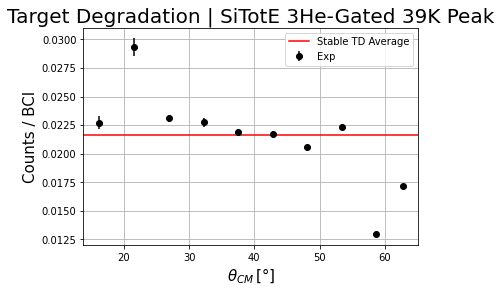

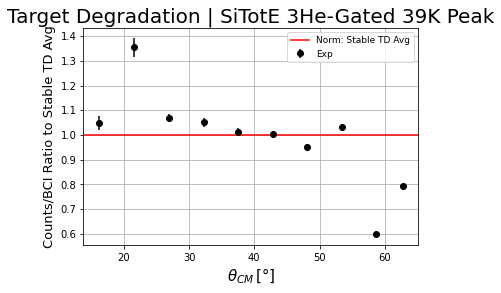

In [16]:
deg = u'\N{DEGREE SIGN}'

# Target Degradation
ax = py.subplot(111)
plt.errorbar(Theta_cm, Si.TD, yerr = Si.u_TD, c = 'k', ls = '', marker = 'o', label = 'Exp')
plt.axhline(y = Si.TD_stable_avg, c = 'r', ls = '-', label = 'Stable TD Average')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel('Counts / BCI', size = 15)
ax.set_title('Target Degradation | SiTotE 3He-Gated 39K Peak', size = 20)
plt.grid(True, which = 'both')
plt.show()

# Target Degradation Ratio
ax = py.subplot(111)
plt.errorbar(Theta_cm, Si.TD_ratio, yerr = Si.u_TD_ratio, c = 'k', ls = '', marker = 'o', label = 'Exp')
plt.axhline(y = 1, c = 'r', ls = '-', label = 'Norm: Stable TD Avg')
plt.legend(loc="best", fontsize = 9)
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel('Counts/BCI Ratio to Stable TD Avg', size = 13)
ax.set_title('Target Degradation | SiTotE 3He-Gated 39K Peak', size = 20)
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Absolute Experimental Differential Cross-Section
</h2>

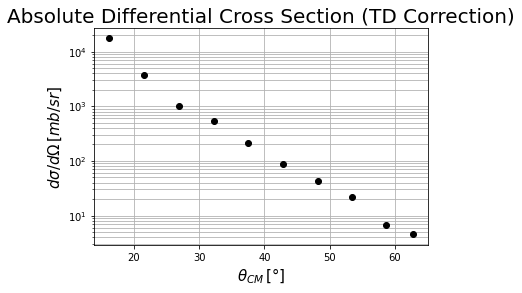

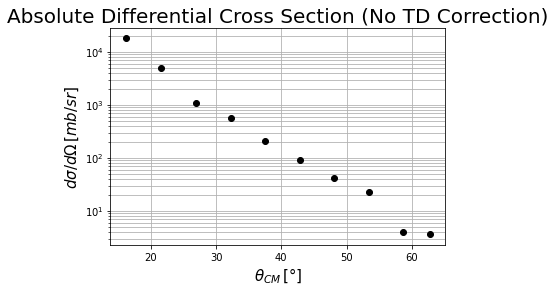

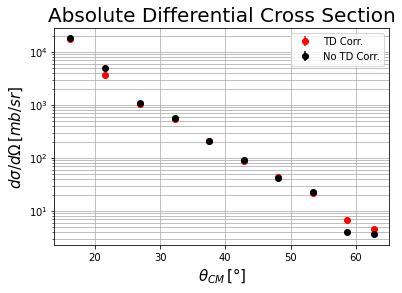

In [17]:
# TD Correction
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross, yerr = K39_P1.u_exp_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$d \sigma / d \Omega \, [mb/sr]$', size = 15)
ax.set_title('Absolute Differential Cross Section (TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# No TD Correction
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross_no_TD, yerr = K39_P1.u_exp_cross_no_TD, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$d \sigma / d \Omega \, [mb/sr]$', size = 15)
ax.set_title('Absolute Differential Cross Section (No TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# TD Correction Comparison
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.exp_cross, yerr = K39_P1.u_exp_cross, c = 'r', ls = '', marker = 'o', label = 'TD Corr.')
plt.errorbar(Theta_cm, K39_P1.exp_cross_no_TD, yerr = K39_P1.u_exp_cross_no_TD, c = 'k', ls = '', marker = 'o', label = 'No TD Corr.')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$d \sigma / d \Omega \, [mb/sr]$', size = 15)
ax.set_title('Absolute Differential Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Rutherford Differential Cross-Section
</h2>

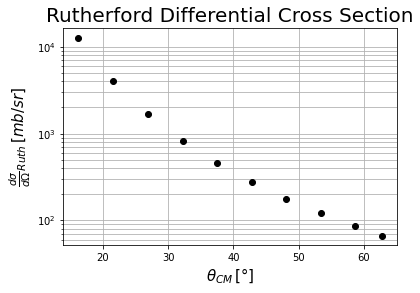

In [18]:
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ruth_cross, yerr = K39_P1.u_ruth_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{CM} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'${\frac{d \sigma}{d \Omega}}_{Ruth} \, [mb/sr]$', size = 15)
ax.set_title('Rutherford Differential Cross Section', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Ratio to Rutherford Differential Cross-Section
</h2>

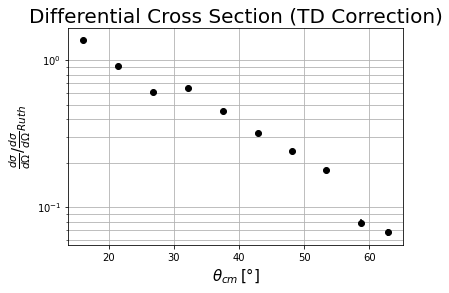

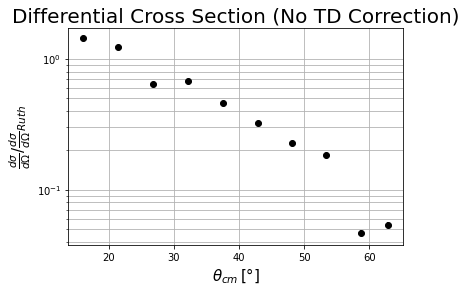

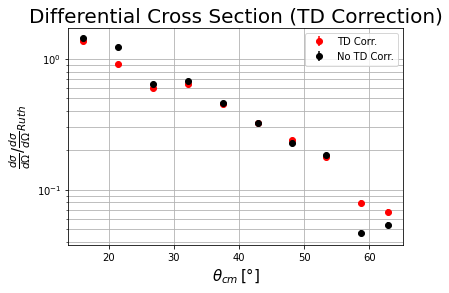

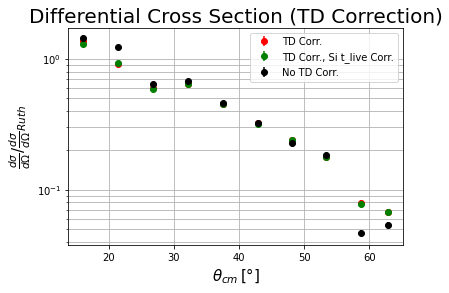

In [19]:
# TD Correction
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Differential Cross Section (TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# No TD Correction
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'k', ls = '', marker = 'o')
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Differential Cross Section (No TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# TD Correction Comparison
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'r', ls = '', marker = 'o', label = 'TD Corr.')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'k', ls = '', marker = 'o', label = 'No TD Corr.')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Differential Cross Section (TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Si livetime Correction Comparison
ax = py.subplot(111)
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'r', ls = '', marker = 'o', label = 'TD Corr.')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_Si_livetime_correction, yerr = K39_P1.u_ratio_cross_Si_livetime_correction, c = 'g', ls = '', marker = 'o', label = 'TD Corr., Si t_live Corr.')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'k', ls = '', marker = 'o', label = 'No TD Corr.')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title('Differential Cross Section (TD Correction)', size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

<h2 style="text-decoration:underline;"> 
    Fresco (3He global OMP) and Experiment Comparison
</h2>

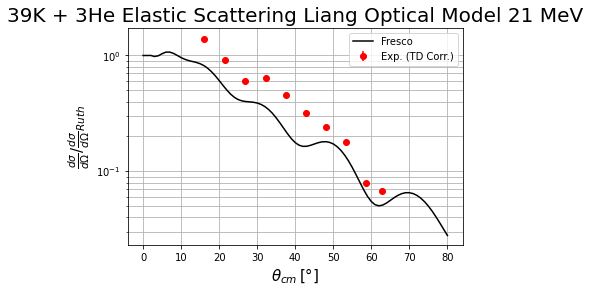

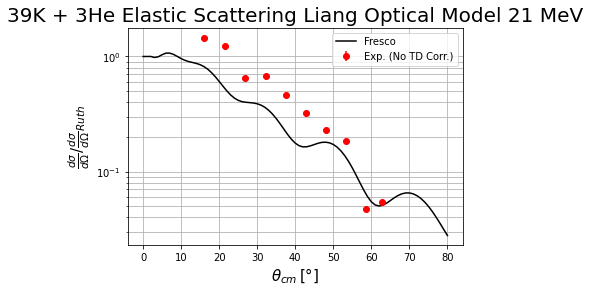

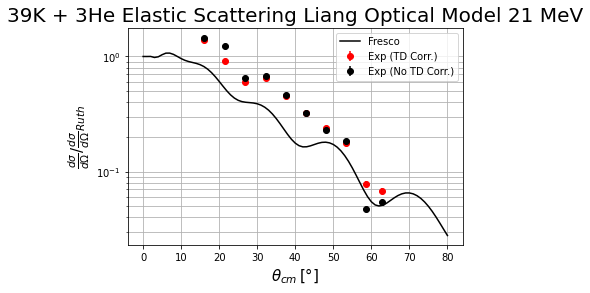

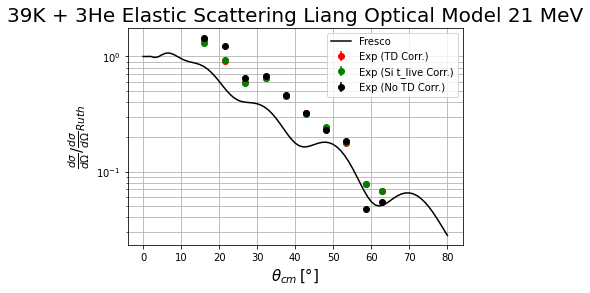

In [20]:
# TD Correction
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'r', ls = '', marker = 'o', label = 'Exp. (TD Corr.)')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# No TD Correction
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'r', ls = '', marker = 'o', label = 'Exp. (No TD Corr.)')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Comparison between TD and no TD correction
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'r', ls = '', marker = 'o', label = 'Exp (TD Corr.)')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'k', ls = '', marker = 'o', label = 'Exp (No TD Corr.)')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

# Si Livetime Correction Comparison
ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, K39_P1.ratio_cross, yerr = K39_P1.u_ratio_cross, c = 'r', ls = '', marker = 'o', label = 'Exp (TD Corr.)')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_Si_livetime_correction, yerr = K39_P1.u_ratio_cross_Si_livetime_correction, c = 'g', ls = '', marker = 'o', label = 'Exp (Si t_live Corr.)')
plt.errorbar(Theta_cm, K39_P1.ratio_cross_no_TD, yerr = K39_P1.u_ratio_cross_no_TD, c = 'k', ls = '', marker = 'o', label = 'Exp (No TD Corr.)')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

In [21]:
print('Exp Cross-Sections:')
print(K39_P1.ratio_cross)
print('\nExp Cross Section Uncertainties:')
print(K39_P1.u_ratio_cross)
print('\nExp Cross-Sections (Corrected for Si t_live):')
print(K39_P1.ratio_cross_Si_livetime_correction)
print('\nExp Cross Section Uncertainties (Corrected for Si t_live):')
print(K39_P1.u_ratio_cross_Si_livetime_correction)
print('\nCM Angles:')
print(Theta_cm)

Exp Cross-Sections:
[1.383132649842395, 0.9180253782765271, 0.6038170358784339, 0.6447435777383927, 0.4543401389793412, 0.3209933667966731, 0.24125067416311832, 0.17876459426440902, 0.0785555642769508, 0.06804578108638738]

Exp Cross Section Uncertainties:
[0.03700529638377799, 0.026944632456905714, 0.01022668704318621, 0.014989992328293612, 0.010509445235298766, 0.006994569595280113, 0.005703789677845699, 0.005711113573750873, 0.004148438026110422, 0.003697847825691405]

Exp Cross-Sections (Corrected for Si t_live):
[1.3013261595871666, 0.9251340770240213, 0.5922158565630327, 0.645324153412698, 0.4535679801132669, 0.31946659187532134, 0.24192373421733276, 0.17943711384248995, 0.07800694827858251, 0.06792208031289289]

Exp Cross Section Uncertainties (Corrected for Si t_live):
[0.03481788894386921, 0.027154120094842204, 0.010031135880597574, 0.015004232587349975, 0.01049210853658141, 0.0069616925755901955, 0.005719976151818987, 0.0057327491883673535, 0.0041195056795544, 0.0036911589083

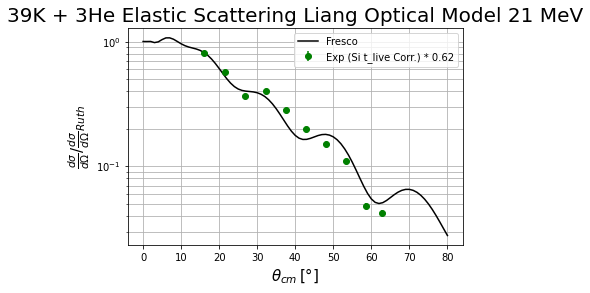

In [22]:
## Try to normalize data to fresco
# (DON'T DO THIS!)

norm = 0.62
exp_sig_norm = []
u_exp_sig_norm = []
for i in range(len(BCI)):
    exp_sig_norm.append(norm * K39_P1.ratio_cross_Si_livetime_correction[i])
    u_exp_sig_norm.append(norm * K39_P1.u_ratio_cross_Si_livetime_correction[i])

ax = py.subplot(111)
ax.plot(theta_fresco, sigma_fresco, c = 'k', label = 'Fresco')
plt.errorbar(Theta_cm, exp_sig_norm, yerr = u_exp_sig_norm, c = 'g', ls = '', marker = 'o', label = 'Exp (Si t_live Corr.) * ' + str(norm))
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

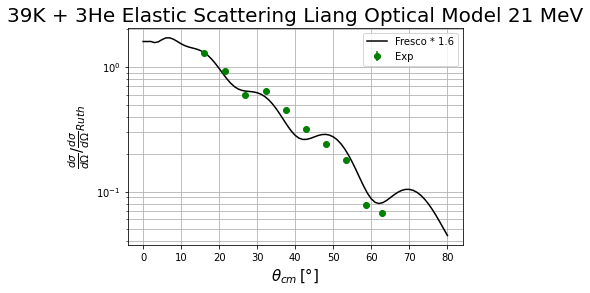

In [23]:
## Normalize fresco to data

ES_norm = 1.6
fresco_sig_norm = []
for i in sigma_fresco:
    fresco_sig_norm.append(ES_norm * i)
    
ax = py.subplot(111)
ax.plot(theta_fresco, fresco_sig_norm, c = 'k', label = 'Fresco * ' + str(ES_norm))
plt.errorbar(Theta_cm, K39_P1.ratio_cross_Si_livetime_correction, yerr = K39_P1.u_ratio_cross_Si_livetime_correction, c = 'g', ls = '', marker = 'o', label = 'Exp')
plt.legend(loc="best")
ax.set_xlabel(r'$\theta_{cm} \, [$' + deg + ']', size = 15)
ax.set_ylabel(r'$\frac{d \sigma}{d \Omega} / {\frac{d \sigma}{d \Omega}}_{Ruth}$', size = 15)
ax.set_title(fresco_title, size = 20)
ax.semilogy()
plt.grid(True, which = 'both')
plt.show()

In [24]:
transfer_norm_param = np.log10(ES_norm)
transfer_norm_param = "{:.3}".format(transfer_norm_param)
print('The norm parameter for pfunk transfer runs = ' + str(transfer_norm_param))

The norm parameter for pfunk transfer runs = 0.204
